# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


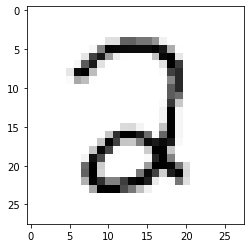

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2482
Training Accuracy: 0.6183, Testing Accuracy: 0.6562



Epoch 10, Loss 0.2324
Training Accuracy: 0.8209, Testing Accuracy: 0.8493



Epoch 20, Loss 0.1519
Training Accuracy: 0.8845, Testing Accuracy: 0.8982



Epoch 30, Loss 0.0805
Training Accuracy: 0.9154, Testing Accuracy: 0.9219



Epoch 40, Loss 0.0576
Training Accuracy: 0.9344, Testing Accuracy: 0.9435



Epoch 50, Loss 0.047
Training Accuracy: 0.9452, Testing Accuracy: 0.9556



Epoch 60, Loss 0.0411
Training Accuracy: 0.9503, Testing Accuracy: 0.9632



Epoch 70, Loss 0.0374
Training Accuracy: 0.9551, Testing Accuracy: 0.9652



Epoch 80, Loss 0.0348
Training Accuracy: 0.9587, Testing Accuracy: 0.9672



Epoch 90, Loss 0.0329
Training Accuracy: 0.9606, Testing Accuracy: 0.9667



Epoch 100, Loss 0.0313
Training Accuracy: 0.9618, Testing Accuracy: 0.9677



Epoch 110, Loss 0.0301
Training Accuracy: 0.9636, Testing Accuracy: 0.9693



Epoch 120, Loss 0.0291
Training Accuracy: 0.9649, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0282
Training Accuracy: 0.9657, Testing Accuracy: 0.9703



Epoch 140, Loss 0.0274
Training Accuracy: 0.9666, Testing Accuracy: 0.9698



Epoch 150, Loss 0.0267
Training Accuracy: 0.9680, Testing Accuracy: 0.9693



Epoch 160, Loss 0.0261
Training Accuracy: 0.9688, Testing Accuracy: 0.9698



Epoch 170, Loss 0.0255
Training Accuracy: 0.9695, Testing Accuracy: 0.9703



Epoch 180, Loss 0.025
Training Accuracy: 0.9700, Testing Accuracy: 0.9708



Epoch 190, Loss 0.0245
Training Accuracy: 0.9707, Testing Accuracy: 0.9713



Epoch 200, Loss 0.024
Training Accuracy: 0.9710, Testing Accuracy: 0.9713



Epoch 210, Loss 0.0236
Training Accuracy: 0.9718, Testing Accuracy: 0.9718



Epoch 220, Loss 0.0231
Training Accuracy: 0.9723, Testing Accuracy: 0.9728



Epoch 230, Loss 0.0227
Training Accuracy: 0.9724, Testing Accuracy: 0.9733



Epoch 240, Loss 0.0223
Training Accuracy: 0.9734, Testing Accuracy: 0.9733



0.029698159540029842

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2474
Training Accuracy: 0.6569, Testing Accuracy: 0.6331



Epoch 10, Loss 0.1076
Training Accuracy: 0.8998, Testing Accuracy: 0.9113



Epoch 20, Loss 0.0818
Training Accuracy: 0.9235, Testing Accuracy: 0.9340



Epoch 30, Loss 0.0699
Training Accuracy: 0.9334, Testing Accuracy: 0.9435



Epoch 40, Loss 0.0628
Training Accuracy: 0.9383, Testing Accuracy: 0.9491



Epoch 50, Loss 0.058
Training Accuracy: 0.9424, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0544
Training Accuracy: 0.9447, Testing Accuracy: 0.9567



Epoch 70, Loss 0.0518
Training Accuracy: 0.9473, Testing Accuracy: 0.9602



Epoch 80, Loss 0.0496
Training Accuracy: 0.9493, Testing Accuracy: 0.9632



Epoch 90, Loss 0.0479
Training Accuracy: 0.9510, Testing Accuracy: 0.9647



Epoch 100, Loss 0.0464
Training Accuracy: 0.9527, Testing Accuracy: 0.9657



Epoch 110, Loss 0.0451
Training Accuracy: 0.9534, Testing Accuracy: 0.9662



Epoch 120, Loss 0.044
Training Accuracy: 0.9545, Testing Accuracy: 0.9672



Epoch 130, Loss 0.0431
Training Accuracy: 0.9554, Testing Accuracy: 0.9667



Epoch 140, Loss 0.0422
Training Accuracy: 0.9557, Testing Accuracy: 0.9667



Epoch 150, Loss 0.0415
Training Accuracy: 0.9565, Testing Accuracy: 0.9672



Epoch 160, Loss 0.0408
Training Accuracy: 0.9569, Testing Accuracy: 0.9672



Epoch 170, Loss 0.0402
Training Accuracy: 0.9577, Testing Accuracy: 0.9672



Epoch 180, Loss 0.0396
Training Accuracy: 0.9582, Testing Accuracy: 0.9677



Epoch 190, Loss 0.0391
Training Accuracy: 0.9589, Testing Accuracy: 0.9677



Epoch 200, Loss 0.0386
Training Accuracy: 0.9594, Testing Accuracy: 0.9682



Epoch 210, Loss 0.0382
Training Accuracy: 0.9604, Testing Accuracy: 0.9682



Epoch 220, Loss 0.0377
Training Accuracy: 0.9606, Testing Accuracy: 0.9682



Epoch 230, Loss 0.0373
Training Accuracy: 0.9607, Testing Accuracy: 0.9693



Epoch 240, Loss 0.037
Training Accuracy: 0.9609, Testing Accuracy: 0.9693



0.043962978762750834

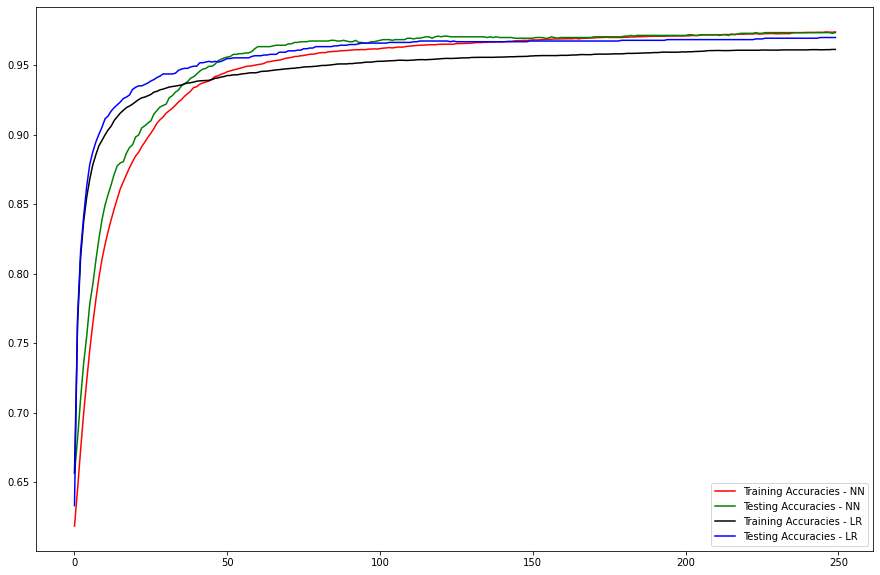

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

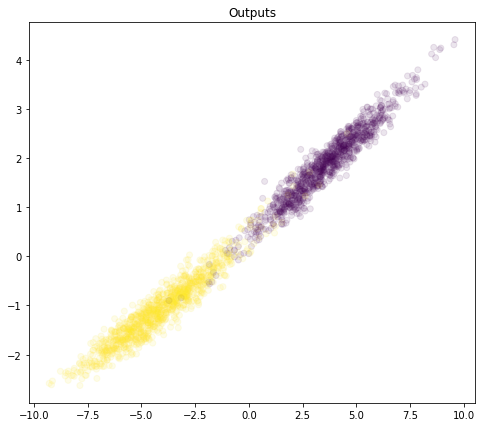

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

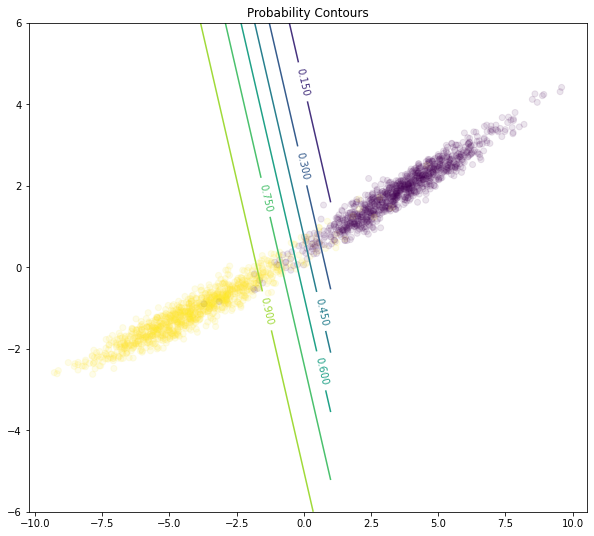

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );